# AIエンジニアを目指す人のための機械学習入門

## 機械学習システムの構築フロートモデルの性能評価

データチェック

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
df = sns.load_dataset("iris")
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [3]:
df.iloc[0, 1] = np.NaN # わざと欠損値を作る
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,NaN,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
import pandas_profiling as pdp
from IPython.display import HTML

profile = pdp.ProfileReport(df)
profile.to_file("profile.html")
HTML(filename="profile.html")

/Users/kkurihara/ai/study/ai-engineer/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Export report to file: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 948.94it/s]


Number of variables,5
Number of observations,150
Missing cells,1
Missing cells (%),0.1%
Duplicate rows,1
Duplicate rows (%),0.7%
Total size in memory,6.0 KiB
Average record size in memory,40.9 B
Numeric,4
Categorical,1
Dataset has 1 (0.7%) duplicate rows,Duplicates


In [5]:
%matplotlib inline

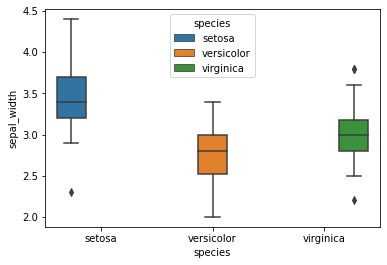

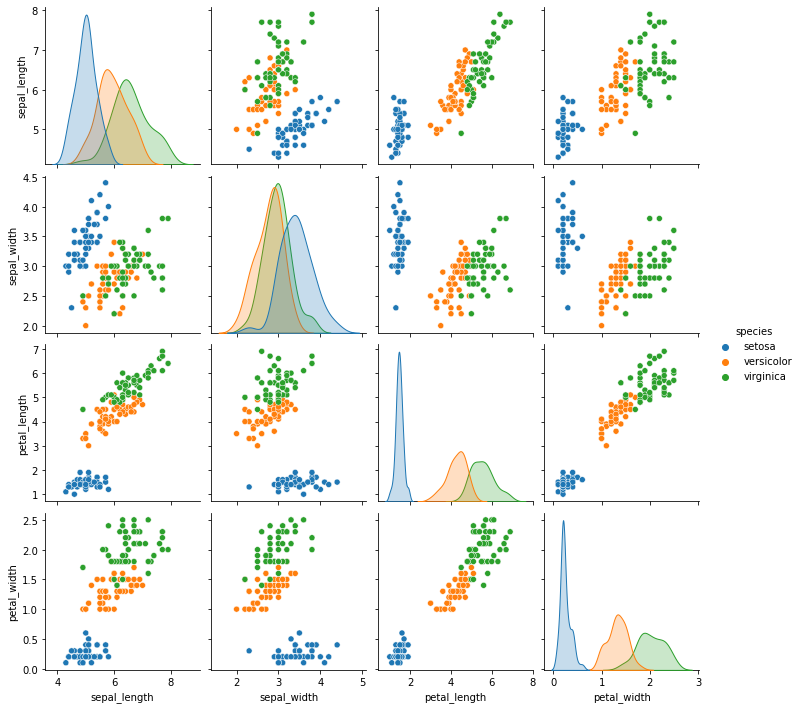

In [6]:
import warnings
warnings.simplefilter("ignore")

sns.boxplot(x="species", y="sepal_width", hue="species", data=df)
sns.pairplot(df, hue="species")

In [7]:
df = df.dropna() # 欠損値の削除

In [8]:
df.iloc[:, 0:3]

,sepal_length,sepal_width,petal_length
1,4.9,3.0,1.4
2,4.7,3.2,1.3
3,4.6,3.1,1.5
4,5.0,3.6,1.4
5,5.4,3.9,1.7
...,...,...,...
145,6.7,3.0,5.2
146,6.3,2.5,5.0
147,6.5,3.0,5.2
148,6.2,3.4,5.4


In [9]:
import warnings

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold


warnings.simplefilter("ignore")

df = df.dropna()
del df["petal_width"] # petal_lengthと相関が強いpetal_widthを削除

df["species"] = df["species"].map({"setosa": 0, "versicolor": 1, "virginica": 2})

y = np.array(df["species"])
X = np.array(df.iloc[:, 0:3]) # 0,1,2列目の３つを取得


outer_loop = KFold(n_splits=5, shuffle=True, random_state=0)
inner_loop = KFold(n_splits=4, shuffle=True, random_state=0)
pipe = Pipeline([("scaler", StandardScaler()), ("logistic", LogisticRegression())])

param_grid = {"logistic__C": [1, 10, 100]}

gs = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring="accuracy", cv=inner_loop)

val_result = np.zeros((5,3))
ol_index = 0

for train_val_index, test_index in outer_loop.split(X):
    X_train_val, X_test = X[train_val_index], X[test_index]
    y_train_val, y_test = y[train_val_index], y[test_index]
    
    gs.fit(X_train_val, y_train_val) # trainで学習してvalで評価
    val_result[ol_index] = gs.cv_results_["mean_test_score"]
    
    print("outer loopの結果その{}: {}".format(ol_index+1, val_result[ol_index]))
    ol_index += 1

print("--\n outer loopの平均結果: {}\n--".format(val_result.mean(axis=0)))


# テストデータで性能確認
clf_pipe = Pipeline([("scaler", StandardScaler()), ("logistic", LogisticRegression(C=100))])

il_index = 0
test_result = np.zeros(5*4)

for train_val_index, test_index in outer_loop.split(X):
    X_train_val, X_test = X[train_val_index], X[test_index]
    y_train__val, y_test = y[train_val_index], y[test_index]
    
    for train_index, val_index in inner_loop.split(X_train_val):
        X_train, X_val = X_train_val[train_index], X_train_val[val_index]
        y_train, y_val = y_train__val[train_index], y_train_val[val_index]
        
        clf_pipe.fit(X_train, y_train) # trainで学習し
        test_result[il_index] = clf_pipe.score(X_test, y_test) #testの正解率を求める
        
        print("inner loopの結果その{}: {}".format(il_index+1, test_result[il_index]))
        il_index += 1

print("--\n テストデータの平均正解率: {}".format(test_result.mean()))

outer loopの結果その1: [0.90689655 0.94942529 0.95775862]
outer loopの結果その2: [0.89913793 0.96637931 0.96637931]
outer loopの結果その3: [0.91637931 0.93304598 0.94137931]
outer loopの結果その4: [0.90747126 0.92471264 0.92471264]
outer loopの結果その5: [0.925      0.95       0.95833333]
--
 outer loopの平均結果: [0.91097701 0.94471264 0.94971264]
--
inner loopの結果その1: 0.9666666666666667
inner loopの結果その2: 0.9333333333333333
inner loopの結果その3: 0.9333333333333333
inner loopの結果その4: 0.9333333333333333
inner loopの結果その5: 0.9666666666666667
inner loopの結果その6: 0.9333333333333333
inner loopの結果その7: 0.9333333333333333
inner loopの結果その8: 0.9666666666666667
inner loopの結果その9: 0.9666666666666667
inner loopの結果その10: 0.9
inner loopの結果その11: 0.9333333333333333
inner loopの結果その12: 0.9333333333333333
inner loopの結果その13: 0.9666666666666667
inner loopの結果その14: 0.9666666666666667
inner loopの結果その15: 0.9666666666666667
inner loopの結果その16: 0.9666666666666667
inner loopの結果その17: 0.9655172413793104
inner loopの結果その18: 0.9655172413793104
inner loopの結果その1